In [1]:
import numpy as np
import pickle
import glob
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

from sklearn.metrics import r2_score
import ipdb

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

from scipy.special import comb

In [2]:
def get_run(run_number, experiment_type):
    """
    Loads the data

    run_number: integer in {1, 2, 3}
    experiment_type: 'ins' or 'frame'
    """
    sampling_matrix = np.load('data/sampling-matrix-{}.p'.format(run_number))
    delays_matrix = np.load('data/delays-{}.p'.format(run_number))
    ins_result = pickle.load(open("data/result-matrix-{}-U2OS-{}.p".format(experiment_type, run_number), 'rb'), 
                             encoding = 'latin1')
    
    return sampling_matrix, delays_matrix, ins_result

def random_binary_matrix(m, n, p=0.5):
    """
    Returns a random binary matrix
    """
    A = np.random.binomial(1,p,size=(m,n))
    return A

def dec_to_bin(x, num_bits):
    assert x < 2**num_bits, "number of bits are not enough"
    u = bin(x)[2:].zfill(num_bits)
    u = list(u)
    u = [int(i) for i in u]
    return np.array(u)

def bin_to_dec(x):
    n = len(x)
    c = 2**(np.arange(n)[::-1])
    return c.dot(x)

def get_sampling_index(x, A, p=0):
    """
    x: sampling index
    A: subsampling matrix
    p: delay
    """
    num_bits = A.shape[0]
    x = dec_to_bin(x, num_bits)
    r = x.dot(A) + p
    return r % 2

def get_random_binary_string(num_bits, p=0.5):
    a = np.random.binomial(1,p,size=num_bits)
    return a

def random_delay_pair(num_bits, target_bit):
    """
    num_bits: number of bits
    location_target: the targeted location (q in equation 26 in https://arxiv.org/pdf/1508.06336.pdf)
    """
    e_q = 2**target_bit
    e_q = dec_to_bin(e_q, num_bits)
    random_seed = get_random_binary_string(num_bits)
    return random_seed, (random_seed+e_q)%2

def make_delay_pairs(num_pairs, num_bits):
    z = []
    z.append(dec_to_bin(0,num_bits))
    for bit_index in range(0, num_bits):
        for pair_idx in range(num_pairs):
            a,b = random_delay_pair(num_bits, bit_index)
            z.append(a)
            z.append(b)
    return z

def myfwht(x):
    """A recursive implementation of the 1D Cooley-Tukey FFT"""
    # x = np.asarray(x, dtype=float)
    N = x.shape[0]
    if N == 1:
        return x
    else:
        X_even = myfwht(x[0:(N//2)])
        X_odd = myfwht(x[(N//2):])
        return np.concatenate([(X_even + X_odd),
                               (X_even - X_odd)])

In [3]:
# experiment files
for f in glob.glob('data/*'):
    print(f)

data/delays-1.p
data/delays-2.p
data/delays-3.p
data/fresh
data/result-matrix-frame-U2OS-1.p
data/result-matrix-frame-U2OS-2.p
data/result-matrix-frame-U2OS-3.p
data/result-matrix-ins-U2OS-1.p
data/result-matrix-ins-U2OS-2.p
data/result-matrix-ins-U2OS-3.p
data/sampling-matrix-1.p
data/sampling-matrix-2.p
data/sampling-matrix-3.p


In [4]:
# this dataset is easier as one can predict the outcome well by looking
# at a small number of nucleotides around the cut
# experiment_type = 'ins'
# this is a harder dataset as you need to look at repeating patterns across the
# cut side -- you need a larger window to observe
experiment_type = 'frame'

d = {'00': 'A', '01': 'T', '10': 'C', '11': 'G' }
left_seq_ref = 'CCAGCCAGAG'
right_seq_ref = 'GACGTGAGAA'


run_number = 1
sampling_matrix, delays_matrix, ins_result = get_run(run_number, experiment_type=experiment_type)

# measurement processing

In [5]:
def results_to_measurements(results):
    measurement_matrix = np.zeros_like(results)

    for i in range(results.shape[0]):
        measurement_matrix[i] = myfwht(results[i])
    return measurement_matrix

In [6]:
measurement_matrix = results_to_measurements(ins_result)

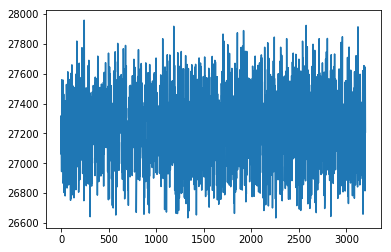

In [7]:
plt.plot(measurement_matrix[:, 0])
plt.show()

In [8]:
# number of samples for each bit (this is including the reference random delay)
(len(delays_matrix)-1)/40

80.0

In [9]:
(delays_matrix[1] + delays_matrix[2]) %2

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

In [10]:
def get_delay_index_base(bit_index, delay_index, D):
    return 1+ 2*D*bit_index + 2*delay_index

def estimate_location(u, num_bits=40, num_delays_per_bit=40):
    location = []
    for bit in range(num_bits):
        sign_total = 0
        for delay in range(num_delays_per_bit):
            delay_0 = get_delay_index_base(bit, delay, num_delays_per_bit)
            delay_1 = delay_0 + 1

            r0 = u[delay_0]
            r1 = u[delay_1]

            sign_total += np.sign(r0)*np.sign(r1)
        location.append(sign_total/num_delays_per_bit)
    location = np.array(location)
    # this is because we need to have bits ordered correctly
    location = location[::-1]
    return location

def get_bin_energies(measurement_matrix):
    return  np.mean(measurement_matrix**2,axis=0)

def evaluate_location(u):
    return np.min(np.abs(u))

def pm_to_zo(pm):
    """
    Goes from plus-minus to zero-one
    """
    zo = np.zeros_like(pm)
    zo[pm < 0] = 1
    return zo.astype(int)

def zo_to_pm(zo):
    """
    Goes from plus-minus to zero-one
    """
    return (-1)**zo

def zo_to_string(u):
    return ''.join([str(i) for i in list(u)])

def string_to_zo(u):
    return np.array([int(i) for i in list(u)])

def my_string_format(s):
    N = len(s)
    return s[:N//2] + ':' + s[N//2:]

def my_print_string(s):
    print(my_string_format(s))
    
def location_to_bin(A, loc):
    """
    Returns the bin where a location is hashed to
    A: sub-sampling matrix
    loc: location of the tone
    """
    hashed_bin = A.dot(loc) % 2
    return hashed_bin 

def support_to_set(support):
    support_set = set()
    for s in support:
        support_set.add(zo_to_string(s))
    return support_set

def set_to_support(the_set):
    locations = []
    for loc in the_set:
        locations.append(string_to_zo(loc))
    return locations

In [11]:
bin_idx = 1
bit_index = 0

sign_total = 0
for i in range(40):
    delay_0 = get_delay_index_base(bit_index,i,40)
    delay_1 = delay_0 + 1
    
    r0 = measurement_matrix[delay_0, bin_idx]
    r1 = measurement_matrix[delay_1, bin_idx]
    
    sign_total += np.sign(r0)*np.sign(r1)

print(sign_total/40)    

0.95


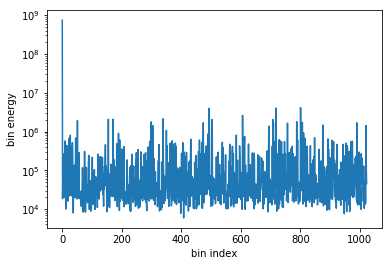

In [12]:
bin_energies = get_bin_energies(measurement_matrix)
plt.semilogy(bin_energies)
plt.xlabel('bin index')
plt.ylabel('bin energy')
plt.show()

In [13]:
sorted_idx = np.argsort(bin_energies)[::-1]

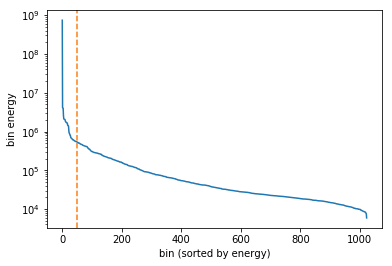

In [14]:
bin_energies = get_bin_energies(measurement_matrix)
plt.semilogy(bin_energies[sorted_idx])
plt.axvline(50, c='C1', linestyle='--')
plt.xlabel('bin (sorted by energy)')
plt.ylabel('bin energy')
plt.show()

In [15]:
chosen_bin = sorted_idx[65]

location_hat = estimate_location(measurement_matrix[:, chosen_bin], 40, 40)

print(location_hat)
print('minimum vote:')
print(evaluate_location(location_hat))

print('--')
print('location found:')
my_print_string(zo_to_string(pm_to_zo(location_hat)))

# these two should be equal if we have found a singleton
print('chosen bin:')
print(chosen_bin)

print('the found tone would alias to bin index:')
print(bin_to_dec(location_to_bin(sampling_matrix, pm_to_zo(location_hat))))

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.
 -1.  1.  1.  1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.]
minimum vote:
1.0
--
location found:
00000000000000001010:00101000000000000000
chosen bin:
944
the found tone would alias to bin index:
944


In [16]:
def get_candidate_locations(measurement_matrix, sampling_matrix=None):
    """
    measurement_matrix:
    sampling_matrix:    if sampling matrix is given check if the found location
                        indeed aliases to that given location
    """
    locations = []
    evaluations = []

    # go over the bins and get the location they predict
    for i in tqdm(range(measurement_matrix.shape[1])):
        # this is the estimated location
        location_hat = estimate_location(measurement_matrix[:, i])
        
        if sampling_matrix is not None:
            aliased_bin = bin_to_dec(location_to_bin(sampling_matrix, pm_to_zo(location_hat)))
            if aliased_bin == i:
                locations.append(location_hat)
                evaluations.append(evaluate_location(location_hat))
        else:
            locations.append(location_hat)
            evaluations.append(evaluate_location(location_hat))
            
    return np.array(locations), np.array(evaluations)

In [17]:
# this is to test that the implementation above is working
locs, evals = get_candidate_locations(measurement_matrix,
                                      sampling_matrix=sampling_matrix)

In [18]:
def get_all_locations(data_indices, experiment_type, use_sampling_matrix=False):
    """
    data_indices:    which data runs to use to get locations
    experiment_type: which experiment (ins/frame)
    use_sampling_matrix:    if set to True, then while finding the singletons, 
                            we check if that found singleton would have hashed to
                            that bin where it was found.  In the case of noise
                            the estimated location might be wrong hence this might be
                            false
    """
    set_of_locs = set()
    
    for i in data_indices:
        run_number = i
        sampling_matrix, delays_matrix, ins_result = get_run(run_number, experiment_type=experiment_type)

        measurement_matrix = np.zeros_like(ins_result)

        for i in range(ins_result.shape[0]):
            measurement_matrix[i] = myfwht(ins_result[i])
        
        
        if use_sampling_matrix:
            locs, evals = get_candidate_locations(measurement_matrix, sampling_matrix)
        else:
            locs, evals = get_candidate_locations(measurement_matrix)

        likely_indices = evals > 0
        
        print('num likely indices: {}'.format(sum(likely_indices)))

        locs  = locs[likely_indices]
        evals = evals[likely_indices]
        
        locs = pm_to_zo(locs)
        
        for loc in locs:
            set_of_locs.add(zo_to_string(loc))
    
    locs = []
    for loc in set_of_locs:
        locs.append(string_to_zo(loc))
    return locs

## get support

Here we obtain the support using the forward algorithm.

In [19]:
print('experiment type: {}'.format(experiment_type))
runs_to_find_support = [1, 2, 3]


# if use_sampling_matrix is True then we filter the found
# singleton locations by checking if they are compatible with the
# bin index they were found from

use_sampling_matrix = True
found_support = get_all_locations(runs_to_find_support, 
                                  experiment_type=experiment_type,
                                  use_sampling_matrix=use_sampling_matrix)

experiment type: frame



num likely indices: 514



num likely indices: 545



num likely indices: 507


let's go over the support we have found -- write a function to augment the support set with the locations having bits reversed.

In [20]:
def support_augmented_with_reversed(support):
    support_set = set()

    for s in support:
        support_set.add(zo_to_string(s))

    support_set_temp = set()
    for s in support_set:
        s_reversed = s[::-1]

        if s_reversed not in support_set:
            support_set_temp.add(s_reversed)
            
    support_set = support_set | support_set_temp
    
    support = []
    for s in support_set:
        support.append(string_to_zo(s))
    
    return support

def next_string_with_same_num_ones(v):
    t = (v | (v-1))+ 1
    w = t | ((( (t & -t) // (v & -v) ) >> 1) - 1 )
    return w


def all_strings_with_k_ones(bit_length,k):
    num_total = int( comb(bit_length,k) )
    c = 2**k - 1
    my_list = []
    for i in range(num_total):
        my_list.append(c)
        if i != num_total - 1:
            c = next_string_with_same_num_ones(c)
        
    return my_list

def all_strings_up_to_k_ones(bit_length,k):
    my_list = []
    
    for i in range(k+1):
        my_list = my_list + all_strings_with_k_ones(bit_length,i)
        
    return my_list

def all_strings_with_given_ones(bit_length, k_list):
    my_list = []
    
    for i in k_list:
        my_list = my_list + all_strings_with_k_ones(bit_length,i)
        
    return my_list

def synthetic_band_support(band_width, num_bits=40):
    max_number = 2**(2*band_width)
    rotate_length = num_bits//2 + band_width
    support = []
    for i in range(max_number):
        binary_loc = dec_to_bin(i, num_bits)
        binary_loc = np.roll(binary_loc, rotate_length)
        support.append(binary_loc)
    return support
    
def synthetic_band_support_capped_degree(band_width, degree_cap, num_bits=40):
    assert band_width >= 0, "width needs to be non-negative"
    assert degree_cap >= 0, "cap needs to be non-negative"
    
    rotate_length = num_bits//2 + band_width
    
    support = []
    
    if isinstance(degree_cap, list):
        all_strings = all_strings_with_given_ones(2*band_width, degree_cap)
    else:
        all_strings = all_strings_up_to_k_ones(2*band_width, degree_cap)
    
    for s in all_strings:
        binary_loc = dec_to_bin(s, num_bits)
        binary_loc = np.roll(binary_loc, rotate_length)
        support.append(binary_loc)
    
    return support

In [21]:
aug_found_support = support_augmented_with_reversed(found_support)
synthetic_support = synthetic_band_support(5)

In [22]:
print('size found-support: {}'.format(len(found_support)))
print('size aug-found-support: {}'.format(len(aug_found_support)))
print('size synthetic-support: {}'.format(len(synthetic_support)))

size found-support: 854
size aug-found-support: 1074
size synthetic-support: 1024


## find coefficients

fix this!

In [23]:
def get_fresh_data(experiment_type):
    u_test = pickle.load(open("data/fresh/random-sample-code-U2OS.p", 'rb'), 
                     encoding = 'latin1')
    
    y_test = pickle.load(open("data/fresh/result-matrix-randsample-{}-U2OS.p".format(experiment_type), 'rb'), 
                     encoding = 'latin1')
    
    return u_test, y_test

def make_system(support, sampling_locations, y, N=None):
    """
    Make measurement system from the samples
    and output
    support:             signal support as binary array
    sampling locations:  sampling locations
    y:                   output
    N:                   number of samples to use
    """
    if N is not None:
        N_max = sampling_locations.shape[0]
        if N < N_max:
            chosen_indices = np.random.choice(N_max, N, replace=False)
            sampling_locations = sampling_locations[chosen_indices]
            y = y[chosen_indices]
    M = sampling_locations.dot(support.T)
    M = M % 2
    M = (-1)**M
    return (M, y)

def train(support, U, y, reg, N=None):
    M, y = make_system(np.vstack(support), U, np.reshape(y,[-1]), N=N)
    reg.fit(M, y)
    return reg

def get_signature(loc, delays):
    return (-1)**(delays.dot(loc) % 2)

In [24]:
U_fresh, y_fresh = get_fresh_data(experiment_type=experiment_type)
U_train, U_test, y_train, y_test = train_test_split(U_fresh, y_fresh, test_size=0.33, random_state=42)

In [25]:
print('train shape: {}'.format(U_train.shape))
print('test shape: {}'.format(U_test.shape))

train shape: (670000, 40)
test shape: (330000, 40)


In [26]:
# run_number = 3
# sampling_matrix, delays_matrix, ins_result, all_sampling_locations = get_run(run_number,
#                                                                              experiment_type=experiment_type)
# U = np.concatenate(all_sampling_locations)

In [27]:
print('number of samples: {0:.2e}'.format(len(U_train)))

number of samples: 6.70e+05


In [28]:
# chose which support you want to use

# support = synthetic_support
# support = aug_found_support
support = found_support

In [29]:
# reg = Lasso(alpha=1e-3, fit_intercept=False)
reg = LinearRegression(fit_intercept=False)

In [30]:
reg = train(support, U_train, y_train, reg, N=int(3e5))

/Users/ocal/pytorch/lib/python3.5/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


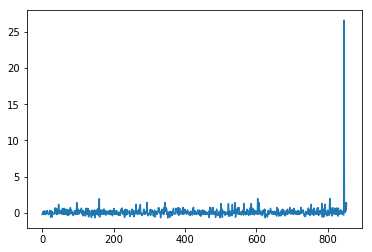

In [31]:
plt.plot(reg.coef_)
plt.show()

In [32]:
# coefficients sorted in it's value in decreasing ordering
sorted_idx = np.argsort(np.abs(reg.coef_))[::-1]

In [33]:
sorted_idx[:10]

array([846, 806, 604, 160, 294, 344, 851, 541,  97, 608])

In [34]:
# print coefficients here
for i in range(20):
    loc = support[sorted_idx[i]]
    val = reg.coef_[sorted_idx[i]]
    
    print('loc: {0} -- val: {1}'.format(my_string_format(zo_to_string(loc)), val))

loc: 00000000000000000000:00000000000000000000 -- val: 26.604196760680914
loc: 00000000000000000100:00010000000000000000 -- val: 1.9962430870014927
loc: 00000000000000001100:00110000000000000000 -- val: 1.9564555826596939
loc: 00000000000000001000:00100000000000000000 -- val: 1.9315874150661148
loc: 00000000000000000010:00001000000000000000 -- val: 1.4204400383727507
loc: 00000000000000110000:11000000000000000000 -- val: 1.420342161415336
loc: 00000000000000000011:00001100000000000000 -- val: 1.416357775303187
loc: 00000000000000000001:00000100000000000000 -- val: 1.4054383904761758
loc: 00000000000000100000:10000000000000000000 -- val: 1.398655368667245
loc: 00000000000000010000:01000000000000000000 -- val: 1.3839839026884904
loc: 00000000000000110000:00000011000000000000 -- val: 1.2765462033976933
loc: 00000000000011000000:00001100000000000000 -- val: 1.2742277448290162
loc: 00000000000000010000:00000001000000000000 -- val: 1.2690502716725174
loc: 00000000000010000000:000010000000000

In [35]:
class SparseWHTModel:
    def __init__(self, support, coef_):
        self.support = support
        self.coef_ = coef_
    
    def predict(self, x):
        M = x.dot(self.support.T)
        M = M % 2
        M = (-1)**M
        return M.dot(self.coef_)
    
    def get_coef(self, zo):
        '''
        returns the coefficient corresponding to the location given with the zo array
        '''
        support_str = [zo_to_string(i) for i in self.support]
        target_str = zo_to_string(zo)
        try:
            index = support_str.index(target_str)
            return self.coef_[index]
        except:
            return 0

In [36]:
model = SparseWHTModel(np.array(support), reg.coef_)

# peeling ideas

In [37]:
print(runs_to_find_support)

[1, 2, 3]


In [38]:
# get a stage where we did not find the support
run_number = 1
sampling_matrix, delays_matrix, ins_result = get_run(run_number, experiment_type=experiment_type)

measurement_matrix = np.zeros_like(ins_result)
for i in range(ins_result.shape[0]):
    measurement_matrix[i] = myfwht(ins_result[i])

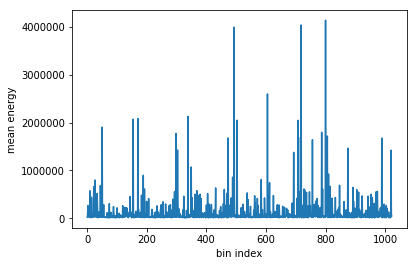

In [39]:
# energies of the bins
bin_energies = np.mean(measurement_matrix**2, axis=0)

plt.plot(bin_energies[1:])
plt.xlabel('bin index')
plt.ylabel('mean energy')
plt.show()

In [40]:
# sort the bin energies
bins_with_energies_sorted = np.argsort(bin_energies)[::-1]

In [41]:
### print(' bin: energy')
print('--------------')
num_to_show = 10
for i in range(num_to_show):
    location_index = bins_with_energies_sorted[i]
    print('{0:4}: {1:.2e}'.format(location_index, bin_energies[location_index]))

--------------
   0: 7.42e+08
 801: 4.14e+06
 719: 4.04e+06
 494: 4.00e+06
 606: 2.60e+06
 339: 2.13e+06
 171: 2.08e+06
 155: 2.07e+06
 504: 2.05e+06
 709: 2.05e+06


In [42]:
target_bin = bins_with_energies_sorted[0]
u = estimate_location(measurement_matrix[:, target_bin])
print(zo_to_string(pm_to_zo(u)))

0000000000000000000000000000000000000000


In [43]:
support_set = set()
for s in found_support:
    support_set.add(zo_to_string(s))

In [44]:
# a location from the found support
test_location = support[sorted_idx[30]]

# the bin index to where the location is hashed to
test_bin_binary  = location_to_bin(sampling_matrix, test_location)

# the bin index in decimal form
test_bin_decimal = bin_to_dec(test_bin_binary)

# I need to define the measurement matrix
new_location = estimate_location(measurement_matrix[:, test_bin_decimal])
new_location_binary = pm_to_zo(new_location)

print('location in the new stage:')
my_print_string(zo_to_string(new_location_binary))
print('target location:')
my_print_string(zo_to_string(test_location))

location in the new stage:
00000000000000001000:00001000000000000000
target location:
00000000000000001000:00001000000000000000


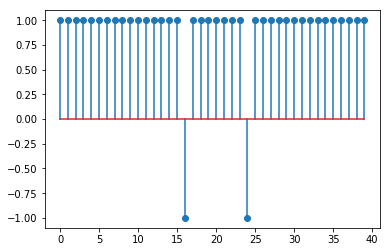

In [45]:
plt.stem(new_location)
plt.show()

This location is a multiton -- lets peel it

In [46]:
test_value = model.get_coef(test_location)*(2**10)
test_signature = get_signature(test_location, np.array(delays_matrix))
q = test_value*test_signature

In [47]:
test_value

-730.2784800930701

In [48]:
test_signature

array([ 1,  1,  1, ..., -1, -1, -1])

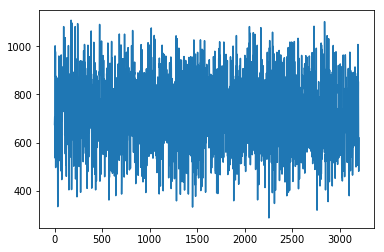

In [49]:
# these should all be positive if the signature is matching in sign
plt.plot(measurement_matrix[:, test_bin_decimal]*np.sign(q))
plt.show()

In [50]:
residual_value = measurement_matrix[:, test_bin_decimal] - q

In [51]:
new_location = estimate_location(residual_value)

In [52]:
new_location

array([ 0.85,  0.9 ,  0.8 ,  0.85,  0.75,  0.5 ,  0.75,  0.75, -0.5 ,
       -0.05,  0.55, -0.05, -0.55,  0.5 ,  0.8 ,  0.65,  0.55,  0.55,
        0.55,  0.9 , -0.45, -0.15,  0.6 , -0.3 , -0.1 ,  0.5 ,  0.6 ,
        0.45,  0.6 ,  0.35,  0.7 ,  0.65,  0.75,  0.9 ,  0.85,  0.8 ,
        0.9 ,  0.95,  0.85,  0.6 ])

# Peeling

In [53]:
def get_run_lists(run_list, experiment_type):
    A_list = []
    D_list = []
    M_list = []
    
    for run_number in run_list:
        A, D, R = get_run(run_number, experiment_type)
        M = results_to_measurements(R)
        
        A_list.append(A)
        M_list.append(M)
        D_list.append(D)
        
    return A_list, M_list, D_list

def peel_once(model, A_list, M_list, D_list):
    """
    Peels all of the support once from the measurements
    model: the model that holds the support and the values
    A_list: sampling matrix list
    M_list: measurement matrices
    D_list: delays
    """
    
    # initialize the list of dictionaries to return
    residual_measurements = []
    for i in range(len(A_list)):
        residual_measurements.append(dict())
    
    # go over the support
    for s in model.support:
        # this is the coefficient
        v = model.get_coef(s)*(2**10)
        
        stage = 0
        # go over each stage
        for A, M, D in zip(A_list, M_list, D_list):
            # the bin where the support goes
            found_bin_binary = location_to_bin(A, s)
            found_bin_decimal = int(bin_to_dec(found_bin_binary))
            
#             if recovered_bin_decimal == 0:
#                 ipdb.set_trace()
            
            # the signature that the location generates
            signature = get_signature(s, np.array(D))
            q = v*signature
            
            # the residual after we peel the support
            residual = M[:, found_bin_decimal] - q
            
            residual_measurements[stage][found_bin_decimal] = residual
            
            stage += 1
    return residual_measurements 

def get_all_locations(M_list, A_list):
    """
    data_indices:    which data runs to use to get locations
    experiment_type: which experiment (ins/frame)
    use_sampling_matrix:    if set to True, then while finding the singletons, 
                            we check if that found singleton would have hashed to
                            that bin where it was found.  In the case of noise
                            the estimated location might be wrong hence this might be
                            false
    """
    set_of_locs = set()
    
    # go over each stage
    for M_dictionary,A in zip(M_list,A_list):
        # the locations found at the stage
        locations = []
        evaluations = []
        
        # go through all the bins in the stage
        for bin_index, bin_measurement in M_dictionary.items():
            location_hat = estimate_location(bin_measurement)
            aliased_bin = bin_to_dec(location_to_bin(A, pm_to_zo(location_hat)))
        
            if aliased_bin == bin_index:
                locations.append(location_hat)
                evaluations.append(evaluate_location(location_hat))
                
        evaluations = np.array(evaluations)
        locations = np.array(locations)
        
        likely_indices = evaluations > 0
        
        locations = locations[likely_indices]
        locations = pm_to_zo(locations)
        
        for loc in locations:
            set_of_locs.add(zo_to_string(loc))

    locations = []
    for loc in set_of_locs:
        locations.append(string_to_zo(loc))
        
    return locations

In [54]:
A_list, M_list, D_list = get_run_lists([1,2,3], experiment_type)

## single round of peeling

In [55]:
residual_measurements = peel_once(model, A_list, M_list, D_list)

In [56]:
new_locations = get_all_locations(residual_measurements, A_list)

In [57]:
new_locations_set = support_to_set(new_locations)
old_locations_set = support_to_set(model.support)

In [58]:
# lets see if we have found anything new from the peeling process
diff_set = new_locations_set.difference(old_locations_set)

for s in diff_set:
    my_print_string(s)

00000000101100000000:00000000000010110000
00000000000010100000:00000000000010100000
00000000000011110000:11110000000000000000
00000000000011010000:00000000000000110100
00000000001001100000:00000000100110000000
00000000000000001110:00000011100000000000
00000000000110000000:00000000000110000000
00000000000011100000:00000011100000000000
00000001010100000000:00000101010000000000
00000000000110000000:00000000000001100000
00000000000000001100:00000000010000000000
00000000000000000101:00000000000101000000
00000000001101110000:00110111000000000000
00000001010000000000:00000000000000000101
00000000100000000000:00000000000000100000
00000001100000000000:00000000000000000110
00000000011100000000:00000000011100000000
00000000000000001011:00000010110000000000
00000000111000000000:00000000000000000011
00000000000011011100:00000000001101110000
00001111110000000000:00111111000000000000
00000000000000000000:00011100000000000000
00000000000000100010:00000000000010001000
00000111110000000000:0001111100000

In [59]:
combined_support_set = old_locations_set | new_locations_set
# update support
support = set_to_support(combined_support_set)

In [60]:
# augment the support with locations with reversed bits
# support = support_augmented_with_reversed(support)

In [61]:
# reg = Lasso(alpha=1e-3, fit_intercept=False)
reg = LinearRegression(fit_intercept=False)

In [62]:
reg = train(support, U_train, y_train, reg, N=int(3e5))

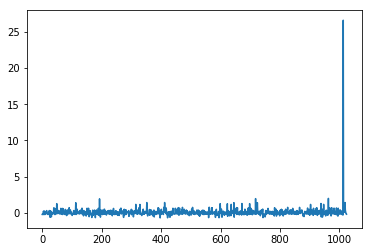

In [63]:
plt.plot(reg.coef_)
plt.show()

In [64]:
model = SparseWHTModel(np.array(support), reg.coef_)

# multiple rounds of peeling

In [65]:
is_done = False

counter = 0
# be careful of this bound!
num_iter_upper_bound = 5

# this contains the singletons recovered in each new round
diff_sets = []
old_locations_set = support_to_set(model.support)
diff_sets.append(old_locations_set)

while not is_done:
    print('-----')
    print('running: {}'.format(counter))

    residual_measurements = peel_once(model, A_list, M_list, D_list)
    new_locations = get_all_locations(residual_measurements, A_list)

    # these are the locations found from the residual measurements
    new_locations_set = support_to_set(new_locations)
    # these are the locations that had been used to create the 
    # residual ameasurements
    old_locations_set = support_to_set(model.support)

    # lets see if we have found anything new from the peeling process
    diff_set = new_locations_set.difference(old_locations_set)
    
    # append the set of newly found singletons
    diff_sets.append(diff_set)
    
    print('number of new locations: {}'.format(len(diff_set)))
    

    combined_support_set = old_locations_set | new_locations_set
    support = set_to_support(combined_support_set)

    print('train the system')
    reg = LinearRegression(fit_intercept=False)
    reg = train(support, U_train, y_train, reg, N=int(5e4))

    model = SparseWHTModel(np.array(support), reg.coef_)
    
    counter += 1
    
    if counter >= num_iter_upper_bound:
        is_done = True
    if not diff_set:
        is_done = True

-----
running: 0
number of new locations: 31
train the system
-----
running: 1
number of new locations: 18
train the system
-----
running: 2
number of new locations: 8
train the system
-----
running: 3
number of new locations: 4
train the system
-----
running: 4
number of new locations: 6
train the system


### look at the coefficients found in each peeling round

In [66]:
v_list = []
l_list = []
# go over the difference sets
for diff_set in diff_sets:
    v = []
    l = []
    # go over the locations in the difference set
    for loc in diff_set:
        v.append(model.get_coef(string_to_zo(loc)))
        l.append(loc)
    v = np.array(v)
    l = np.array(l)
    v_list.append(v)
    l_list.append(l)

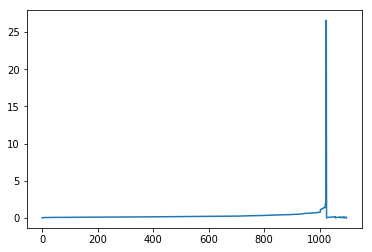

In [67]:
v_list2 = []
for v in v_list:
    v_list2.append(np.sort(np.abs(v)))
    v_list2.append(np.array([0]))
plt.plot(np.concatenate(v_list2))
plt.show()

## testing on new data

Something to do is to check the energy of the coefficients found without peeling and then with peeling to see how much energy are there in the new coefficients.

In [68]:
# uncomment below if you want to see augmenting with the
# reversed bits help

support = support_augmented_with_reversed(support)
reg = train(support, U_train, y_train, reg, N=int(3e5))
model = SparseWHTModel(np.array(support), reg.coef_)

In [69]:
y_test_hat = model.predict(U_test)

print('r2: {0:0.3f}'.format(r2_score(y_test, y_test_hat)))

r2: 0.880


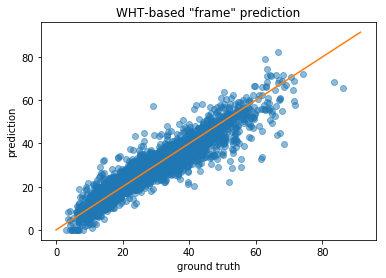

In [70]:
# the number of data points are a lot
# so this plot takes a lot of time

num_to_plot = 5000
chosen_indices = np.random.choice(len(y_test), num_to_plot, replace=False)

# zero out the negative indices
y_test_plot = y_test[chosen_indices]
y_hat_plot = y_test_hat[chosen_indices]
# to clip at 0 on the lower side
y_hat_plot[y_hat_plot <= 0] = 0

plt.scatter(y_test_plot, y_hat_plot, alpha=0.5)
plt.plot([0,max(y_test)],[0,max(y_test)], c='C1')
plt.xlabel('ground truth')
plt.ylabel('prediction')
plt.title('WHT-based \"{}\" prediction'.format(experiment_type))
plt.show()

In [71]:
for s in model.support:
    my_print_string(zo_to_string(s))

00000000000000001000:00000000000000001000
00000010000000000000:00000000000000001000
00000000110111000000:11011100000000000000
00000000000001100100:00000000000110010000
00000000000000010000:00000000000000000000
00000000000000101000:00000000000000000000
00000000000000000000:10110000000000000000
00000000001011000000:00000000001011000000
00000000000001010100:00000000000000000000
00000000000000001110:00000011100000000000
00000000000000000110:00000000010000000000
01110000000000000000:00000111000000000000
00000000000100000000:00000000000000000001
00000000001010110000:00101011000000000000
00000000000000000101:00000000000101000000
00000000000000001110:00000000110000000000
00000010010000000000:00100100000000000000
00011100000000000000:00011100000000000000
00000000010001000000:01000100000000000000
00000000010100000000:00000001010000000000
00000000000001011000:00000101100000000000
00000000000010000000:00000000000000100000
00000010101000000000:00001010100000000000
00000000000000000010:0000000000000